<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Project-setup" data-toc-modified-id="Project-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Project setup</a></span></li><li><span><a href="#Dataset-overview" data-toc-modified-id="Dataset-overview-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset overview</a></span></li><li><span><a href="#K-Nearest-Neighbor-modeling" data-toc-modified-id="K-Nearest-Neighbor-modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>K-Nearest Neighbor modeling</a></span></li><li><span><a href="#Multi-layer-Perceptron-classifier-modeling" data-toc-modified-id="Multi-layer-Perceptron-classifier-modeling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Multi-layer Perceptron classifier modeling</a></span><ul class="toc-item"><li><span><a href="#Train-and-Test-sets-performance-comparison" data-toc-modified-id="Train-and-Test-sets-performance-comparison-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Train and Test sets performance comparison</a></span></li><li><span><a href="#Increasing-hidden-layers" data-toc-modified-id="Increasing-hidden-layers-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Increasing hidden layers</a></span></li><li><span><a href="#Test-with-more-folds-for-train-and-test-sets" data-toc-modified-id="Test-with-more-folds-for-train-and-test-sets-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Test with more folds for train and test sets</a></span></li><li><span><a href="#Modifying-the-default-learning-rate" data-toc-modified-id="Modifying-the-default-learning-rate-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Modifying the default learning rate</a></span><ul class="toc-item"><li><span><a href="#20-times-higher-learning-rate" data-toc-modified-id="20-times-higher-learning-rate-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>20 times higher learning rate</a></span></li><li><span><a href="#50-times-higher-learning-rate" data-toc-modified-id="50-times-higher-learning-rate-4.4.2"><span class="toc-item-num">4.4.2&nbsp;&nbsp;</span>50 times higher learning rate</a></span></li></ul></li></ul></li><li><span><a href="#Random-Forest-modeling" data-toc-modified-id="Random-Forest-modeling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Random Forest modeling</a></span></li><li><span><a href="#Visualization-of-MLP-weights" data-toc-modified-id="Visualization-of-MLP-weights-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Visualization of MLP weights</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Summary</a></span></li></ul></div>

# Building A Handwritten Digits Classifier
The goals of this Project to explore the effectiveness of deep, feedforward neural networks at classifying images.

Scikit-learn contains a number of [datasets](https://scikit-learn.org/stable/datasets/index.html) pre-loaded with the library, within the namespace of **sklearn.datasets**. The _load_digits()_ function returns a copy of the hand-written digits dataset from [UCI](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits).

Because dataframes are a tabular representation of data, each image is represented as a row of pixel values. To visualize an image from the dataframe, we need to reshape the image back to its original dimensions (28 x 28 pixels). To visualize the image, we need to reshape these pixel values back into the 28 by 28 and plot them on a coordinate grid.

## Project setup

In [176]:
from sklearn.datasets import load_digits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor

In [177]:
plt.style.use('ggplot')

## Dataset overview
To reshape the image, we need to convert a training example to a numpy array (excluding the label column) and pass the result into that into the _numpy.reshape()_ function.

In [178]:
dataset = load_digits()
data = pd.DataFrame(dataset['data'])
data.head(3)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0


In [179]:
target = pd.Series(dataset['target'])
target.shape

(1797,)

In [180]:
target.sample(10)

1429    4
834     6
1494    0
816     8
437     2
457     5
1185    8
945     8
1436    1
1500    1
dtype: int64

In [181]:
first_image = data.iloc[0]
np_image = first_image.values
np_image = np_image.reshape(8,8)

Let's see some images:

Targets
----
0
1
4
9
1
7
7
3


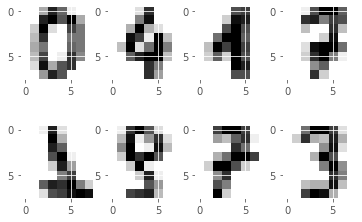

In [182]:
f, ax = plt.subplots(2, 4)

print('Targets')
print(4*'-')
for i in range(4):
    img_idx1 = i*100
    img_idx2 = 1000 + img_idx1

    image_r1 = data.iloc[img_idx1].values.reshape(8,8)
    image_r2 = data.iloc[img_idx2].values.reshape(8,8)

    ax[0, i].imshow(image_r1, cmap='gray_r')
    ax[1, i].imshow(image_r2, cmap='gray_r')
    
    print(target.iloc[img_idx1])
    print(target.iloc[img_idx2])

## K-Nearest Neighbor modeling

In [185]:
def train(X, y, n, learning_rate_init=0.001):
    """
    Train a K-Nearest Neighbor model and return the trained model
    """
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X, y)

    return knn

def test(model, X_test, y_test):
    """
    Predict values using a trained model and return the predictions
    """
    score = model.score(X_test, y_test)
    return score

def cross_validate(features, labels, n, n_folds=4, learning_rate_init=0.001):
    """
    Validation based on train/test split using K-Folding
    """
    accuracies = []
    
    kf = KFold(n_splits = n_folds, random_state=2)
    for train_idx, test_idx in kf.split(features):
        X = features.loc[train_idx]
        y = labels.loc[train_idx]
        X_test = features.loc[test_idx]
        y_test = labels.loc[test_idx]

        model = train(X, y, n, learning_rate_init=learning_rate_init)
        model_score = test(model, X_test, y_test)
        accuracies.append(model_score)
        
    return accuracies

In [186]:
# test
scores = cross_validate(data, target, 3)
print(scores, np.mean(scores))

[0.9577777777777777, 0.9487750556792873, 0.9732739420935412, 0.9710467706013363] 0.9627183865379857


In [187]:
# test with different clusters quantity
avg_scores = []
neighbor_q = range(1,31)
for n in neighbor_q:
    scores = cross_validate(data, target, n)
    avg_scores.append(np.mean(scores))

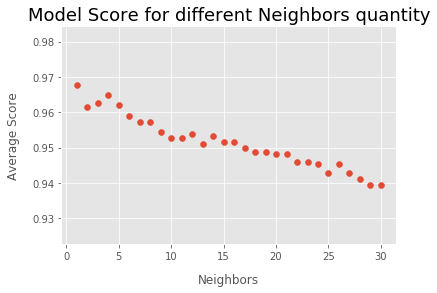

In [188]:
ax = plt.subplot()
plt.scatter(neighbor_q, avg_scores)
# Plot setup
ax.set_title('Model Score for different Neighbors quantity', size=18)
ax.set_ylabel('Average Score', labelpad=12)
ax.set_xlabel('Neighbors', labelpad=12)
plt.show()

It seems that the model cannot be improved by incrementing the neighbors quantity.

## Multi-layer Perceptron classifier modeling

In [189]:
# Redefine train(), then we can still use cross_validate()
def train(X, y, n=(100,), learning_rate_init=0.001):
    """
    Train a MLP Classifier model and return the trained model
    """
    mlp = MLPClassifier(hidden_layer_sizes=n, max_iter=2000, learning_rate_init=0.001)
    mlp.fit(X, y)

    return mlp

In [190]:
# test
scores = cross_validate(data, target, (10,))
print(scores)
print(np.mean(scores))

[0.9311111111111111, 0.89086859688196, 0.9354120267260579, 0.8574610244988864]
0.9037131898045039


In [191]:
# test with different neurons quantity in one hidden layer
avg_scores_1hl_4f = []
neurons_q = [8, 16, 32, 64, 128, 256]
for n in neurons_q:
    scores = cross_validate(data, target, (n,))
    avg_scores_1hl_4f.append(np.mean(scores))

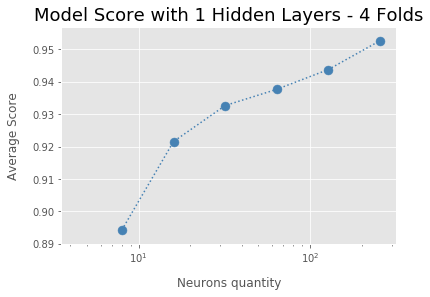

In [192]:
ax = plt.subplot()
plt.plot(neurons_q, avg_scores_1hl_4f, c='steelblue', ls=':')
plt.scatter(neurons_q, avg_scores_1hl_4f, s=80, c='steelblue')
# Plot setup
ax.set_title('Model Score with 1 Hidden Layers - 4 Folds', size=18)
ax.set_ylabel('Average Score', labelpad=12)
ax.set_xlabel('Neurons quantity', labelpad=12)
ax.set_xscale('log')
plt.show()

This model shows that the more neurons the hidden layer has, the better the model performance.

### Train and Test sets performance comparison
We can run a test to compare how the model performs using train and test sets for predictions. We suppose that the train set will perform always better that the test set. If the model is good, the performance between train and test sets should be similar. On the other side, if the performance is much lower with the test set compared to the train set, then the model may be overfitted.

In [193]:
def train_test_perf_comparison(features, labels, n):
    """
    Compare the performance with train and test sets.
    Models that overfit tend to perform well on the train set but
    poorly on the test 
    """
    accuracies_train = []
    accuracies_test = []
    
    kf = KFold(n_splits = 4, random_state=2)
    for train_idx, test_idx in kf.split(features):
        X = features.loc[train_idx]
        y = labels.loc[train_idx]
        X_test = features.loc[test_idx]
        y_test = labels.loc[test_idx]

        model = train(X, y, n)
        model_score_test = test(model, X_test, y_test)
        model_score_train = test(model, X, y)
        accuracies_train.append(model_score_train)
        accuracies_test.append(model_score_test)
        
    return accuracies_train, accuracies_test

In [194]:
avg_scores_train = []
avg_scores_test = []
for n in neurons_q:
    s_train, s_test = train_test_perf_comparison(data, target, n)
    avg_scores_train.append(np.mean(s_train))
    avg_scores_test.append(np.mean(s_test))

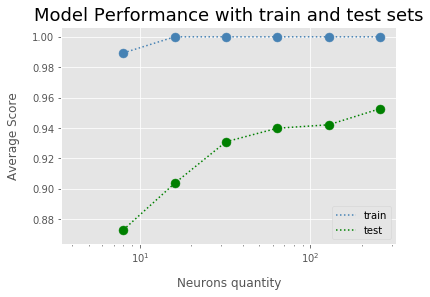

In [195]:
ax = plt.subplot()

ax.plot(neurons_q, avg_scores_train, c='steelblue', ls=':', label='train')
ax.scatter(neurons_q, avg_scores_train, s=80, c='steelblue')

ax.plot(neurons_q, avg_scores_test, c='green', ls=':', label='test')
ax.scatter(neurons_q, avg_scores_test, s=80, c='green')

# Plot setup
ax.set_title('Model Performance with train and test sets', size=18)
ax.set_ylabel('Average Score', labelpad=12)
ax.set_xlabel('Neurons quantity', labelpad=12)
ax.legend()
ax.set_xscale('log')
plt.show()

We can confirm that the model's performance is poor when there are few neurons in the hidden layer. As the neurons quantity increases, the model improves. The improvement is not much when comparing the 64 neurons model to the 256 neurons. We should consider that the increase in neurons quantity makes the model slower and need more computing power. The final decision should evaluate a tradeoff between performance and computer resources.

### Increasing hidden layers

In [196]:
# test with different neurons quantity in two hidden layer
avg_scores_2hl_4f = []
neurons_q = [8, 16, 32, 64, 128, 256]
for n in neurons_q:
    scores = cross_validate(data, target, (n,n))
    avg_scores_2hl_4f.append(np.mean(scores))

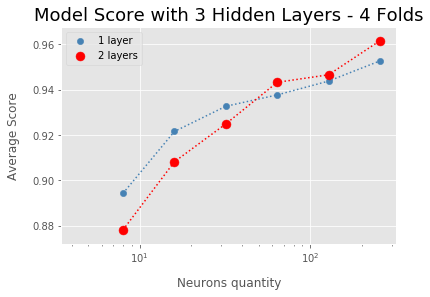

In [197]:
ax = plt.subplot()

plt.plot(neurons_q, avg_scores_1hl_4f, c='steelblue', ls=':')
plt.scatter(neurons_q, avg_scores_1hl_4f, s=40, c='steelblue', label='1 layer')

plt.plot(neurons_q, avg_scores_2hl_4f, c='r', ls=':')
plt.scatter(neurons_q, avg_scores_2hl_4f, s=80, c='r', label='2 layers')

# Plot setup
ax.set_title('Model Score with 3 Hidden Layers - 4 Folds', size=18)
ax.set_ylabel('Average Score', labelpad=12)
ax.set_xlabel('Neurons quantity', labelpad=12)
ax.legend()
ax.set_xscale('log')
plt.show()

Lets try now with 3 hidden layers:

In [198]:
# test with different neurons quantity in two hidden layer
avg_scores_3hl_4f = []
neurons_q = [8, 16, 32, 64, 128, 256]
for n in neurons_q:
    scores = cross_validate(data, target, (n,n,n))
    avg_scores_3hl_4f.append(np.mean(scores))

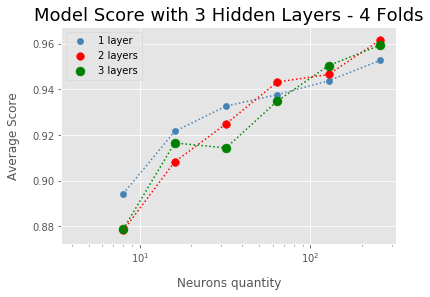

In [199]:
ax = plt.subplot()

plt.plot(neurons_q, avg_scores_1hl_4f, c='steelblue', ls=':')
plt.scatter(neurons_q, avg_scores_1hl_4f, s=40, c='steelblue', label='1 layer')

plt.plot(neurons_q, avg_scores_2hl_4f, c='r', ls=':')
plt.scatter(neurons_q, avg_scores_2hl_4f, s=60, c='r', label='2 layers')

plt.plot(neurons_q, avg_scores_3hl_4f, c='g', ls=':')
plt.scatter(neurons_q, avg_scores_3hl_4f, s=80, c='g', label='3 layers')

# Plot setup
ax.set_title('Model Score with 3 Hidden Layers - 4 Folds', size=18)
ax.set_ylabel('Average Score', labelpad=12)
ax.set_xlabel('Neurons quantity', labelpad=12)
ax.legend()
ax.set_xscale('log')
plt.show()

### Test with more folds for train and test sets
Using more hidden layers is known to increase the amount of overfitting that happens. To help us prevent overfitting, let's increase the number of folds we use for k-fold cross validation to 6.

In [200]:
n_folds = 6

avg_scores_1hl_6f = []
avg_scores_2hl_6f = []
avg_scores_3hl_6f = []

neurons_q = [8, 16, 32, 64, 128, 256]

for n in neurons_q:
    scores_1hl = cross_validate(data, target, (n,), n_folds)
    scores_2hl = cross_validate(data, target, (n,n), n_folds)
    scores_3hl = cross_validate(data, target, (n,n,n), n_folds)

    avg_scores_1hl_6f.append(np.mean(scores_1hl))
    avg_scores_2hl_6f.append(np.mean(scores_2hl))
    avg_scores_3hl_6f.append(np.mean(scores_3hl))

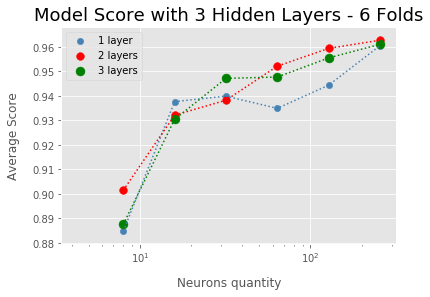

In [201]:
ax = plt.subplot()

plt.plot(neurons_q, avg_scores_1hl_6f, c='steelblue', ls=':')
plt.scatter(neurons_q, avg_scores_1hl_6f, s=40, c='steelblue', label='1 layer')

plt.plot(neurons_q, avg_scores_2hl_6f, c='r', ls=':')
plt.scatter(neurons_q, avg_scores_2hl_6f, s=60, c='r', label='2 layers')

plt.plot(neurons_q, avg_scores_3hl_6f, c='g', ls=':')
plt.scatter(neurons_q, avg_scores_3hl_6f, s=80, c='g', label='3 layers')

# Plot setup
ax.set_title('Model Score with 3 Hidden Layers - 6 Folds', size=18)
ax.set_ylabel('Average Score', labelpad=12)
ax.set_xlabel('Neurons quantity', labelpad=12)
ax.legend()
ax.set_xscale('log')
plt.show()

### Modifying the default learning rate
The learning rate is a parameter that may change the speed and final accuracy of the model. Lets try by increasing its default value.

#### 20 times higher learning rate

In [202]:
n_folds = 6

avg_scores_1hl_6f = []
avg_scores_2hl_6f = []
avg_scores_3hl_6f = []

neurons_q = [8, 16, 32, 64, 128, 256]

for n in neurons_q:
    scores_1hl = cross_validate(data, target, (n,), n_folds, learning_rate_init=0.02)
    scores_2hl = cross_validate(data, target, (n,n), n_folds, learning_rate_init=0.02)
    scores_3hl = cross_validate(data, target, (n,n,n), n_folds, learning_rate_init=0.02)

    avg_scores_1hl_6f.append(np.mean(scores_1hl))
    avg_scores_2hl_6f.append(np.mean(scores_2hl))
    avg_scores_3hl_6f.append(np.mean(scores_3hl))

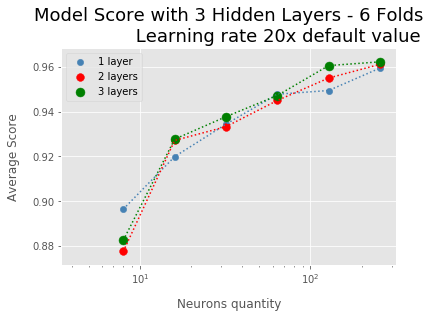

In [203]:
ax = plt.subplot()

plt.plot(neurons_q, avg_scores_1hl_6f, c='steelblue', ls=':')
plt.scatter(neurons_q, avg_scores_1hl_6f, s=40, c='steelblue', label='1 layer')

plt.plot(neurons_q, avg_scores_2hl_6f, c='r', ls=':')
plt.scatter(neurons_q, avg_scores_2hl_6f, s=60, c='r', label='2 layers')

plt.plot(neurons_q, avg_scores_3hl_6f, c='g', ls=':')
plt.scatter(neurons_q, avg_scores_3hl_6f, s=80, c='g', label='3 layers')

# Plot setup
ax.set_title('Model Score with 3 Hidden Layers - 6 Folds\n \
                Learning rate 20x default value', size=18)
ax.set_ylabel('Average Score', labelpad=12)
ax.set_xlabel('Neurons quantity', labelpad=12)
ax.legend()
ax.set_xscale('log')
plt.show()

#### 50 times higher learning rate

In [204]:
n_folds = 6

avg_scores_1hl_6f = []
avg_scores_2hl_6f = []
avg_scores_3hl_6f = []

neurons_q = [8, 16, 32, 64, 128, 256]

for n in neurons_q:
    scores_1hl = cross_validate(data, target, (n,), n_folds, learning_rate_init=0.05)
    scores_2hl = cross_validate(data, target, (n,n), n_folds, learning_rate_init=0.05)
    scores_3hl = cross_validate(data, target, (n,n,n), n_folds, learning_rate_init=0.05)

    avg_scores_1hl_6f.append(np.mean(scores_1hl))
    avg_scores_2hl_6f.append(np.mean(scores_2hl))
    avg_scores_3hl_6f.append(np.mean(scores_3hl))

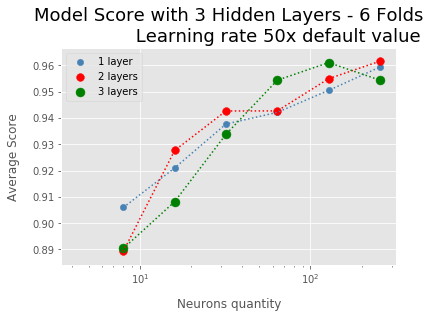

In [205]:
ax = plt.subplot()

plt.plot(neurons_q, avg_scores_1hl_6f, c='steelblue', ls=':')
plt.scatter(neurons_q, avg_scores_1hl_6f, s=40, c='steelblue', label='1 layer')

plt.plot(neurons_q, avg_scores_2hl_6f, c='r', ls=':')
plt.scatter(neurons_q, avg_scores_2hl_6f, s=60, c='r', label='2 layers')

plt.plot(neurons_q, avg_scores_3hl_6f, c='g', ls=':')
plt.scatter(neurons_q, avg_scores_3hl_6f, s=80, c='g', label='3 layers')

# Plot setup
ax.set_title('Model Score with 3 Hidden Layers - 6 Folds\n \
                Learning rate 50x default value', size=18)
ax.set_ylabel('Average Score', labelpad=12)
ax.set_xlabel('Neurons quantity', labelpad=12)
ax.legend()
ax.set_xscale('log')
plt.show()

## Random Forest modeling

In [208]:
# Redefine train(), using random forest
def train(X, y, n=100, learning_rate_init=0.001):
    """
    Train a Random model and return the trained model
    """
    rf = RandomForestRegressor(n_estimators=n, random_state=0)
    rf.fit(X, y)

    return rf

In [209]:
# test with different neurons quantity in two hidden layer
avg_scores_rf = []
trees_q = np.logspace(1, 2.5, 10, dtype=int)
for n in trees_q:
    scores = cross_validate(data, target, n)
    avg_scores_rf.append(np.mean(scores))

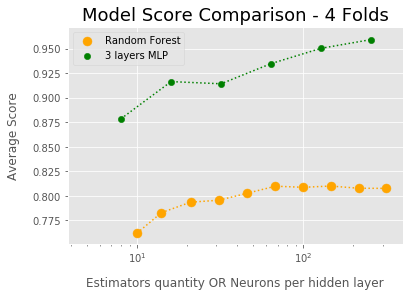

In [210]:
ax = plt.subplot()

ax.plot(trees_q, avg_scores_rf, c='orange', ls=':')
ax.scatter(trees_q, avg_scores_rf, s=80, c='orange', label='Random Forest')

ax.plot(neurons_q, avg_scores_3hl_4f, c='g', ls=':')
ax.scatter(neurons_q, avg_scores_3hl_4f, s=40, c='g', label='3 layers MLP')

# Plot setup
ax.set_title('Model Score Comparison - 4 Folds', size=18)
ax.set_ylabel('Average Score', labelpad=12)
ax.set_xlabel('Estimators quantity OR Neurons per hidden layer', labelpad=12)
ax.set_xscale('log')
ax.legend()
plt.show()

## Visualization of MLP weights 
Sometimes looking at the learned coefficients of a neural network can provide insight into the learning behavior. For example if weights look unstructured, maybe some were not used at all, or if very large coefficients exist, maybe regularization was too low or the learning rate too high.

In [211]:
def cross_validate_and_visualize(features, labels, n, n_folds=4):
    """
    Validation based on train/test split using K-Folding
    An optional visualization is added with parameter 'show_visualization'
    """
    accuracies = []
    
    kf = KFold(n_splits = n_folds, random_state=0)
    
    fold_counter = 1
    for train_idx, test_idx in kf.split(features):
        print('Fold number {}'.format(fold_counter))
        print(80*'-')
        X = features.loc[train_idx]
        y = labels.loc[train_idx]
        X_test = features.loc[test_idx]
        y_test = labels.loc[test_idx]

        model = MLPClassifier(hidden_layer_sizes=n, max_iter=1000,
                              learning_rate_init=.005)
        model.fit(X, y)
        model_score = test(model, X_test, y_test)
        accuracies.append(model_score)
        
        print("Training set score: %f" % model.score(X, y))
        print("Test set score: %f" % model.score(X_test, y_test))
        
        fold_counter += 1
        
        # Visualization of MLP weights
        fig, ax = plt.subplots(8, 8,figsize=(6,6))
        # use global min / max to ensure all weights are shown on the same scale
        vmin, vmax = model.coefs_[2].min(), model.coefs_[2].max()
        # Showing only the last hidden layer
        for coef, ax in zip(model.coefs_[2].T, ax.ravel()):
            ax.matshow(coef.reshape(8, 8), cmap=plt.cm.gray, vmin=.5 * vmin,
                       vmax=.5 * vmax)
            ax.set_xticks(())
            ax.set_yticks(())
        plt.show()
        
    return accuracies

Fold number 1
--------------------------------------------------------------------------------
Training set score: 1.000000
Test set score: 0.962222


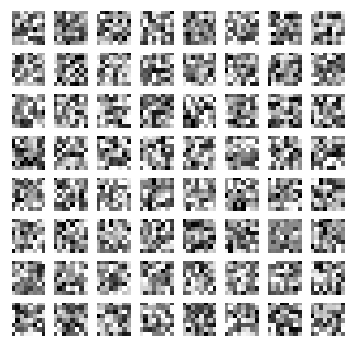

Fold number 2
--------------------------------------------------------------------------------
Training set score: 1.000000
Test set score: 0.937639


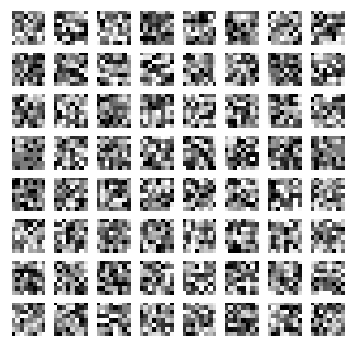

Fold number 3
--------------------------------------------------------------------------------
Training set score: 1.000000
Test set score: 0.975501


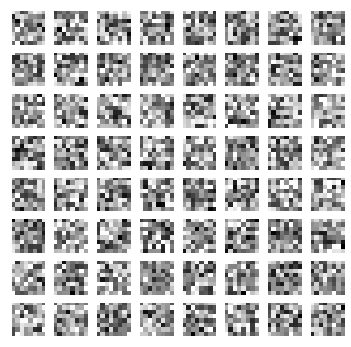

Fold number 4
--------------------------------------------------------------------------------
Training set score: 1.000000
Test set score: 0.906459


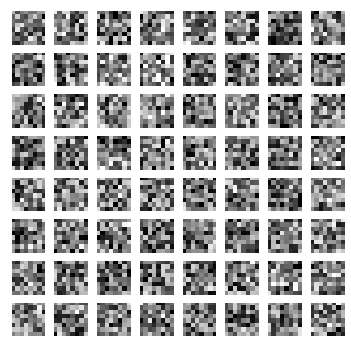

In [213]:
score = cross_validate_and_visualize(data, target, (64,64,64))

## Summary
For this kind of project, a K-Nearest Neighbor (KNN) performed reasonably. However, there are a few downsides to using k-nearest neighbors:

- High memory usage (for each new unseen observation, many comparisons need to be made to seen observations)
- No model representation to debug and explore
  
This is why we test also MLP Classifier models, which is a feed forward neural network with hidden layers of neurons. They perform better when we increase the numbers of neurons. If we increase also the number of hidden layers, we will reach a higher performance as well.

When compare models using 1, 2 and 3 layers, we observed:
- Maximum performance, slightly above 96%, reached in this particular case when using 2 hidden layers and 256 neurons per layer.
- There is no linearity between model performance and layer quantity but there is a tendency to have better performance when incrementing the hidden layers and / or neurons per layer.
- With more than 64 neurons per layer, there is not much improvement in performance.

Regarding the train and test sets, we started with a 4 folds method and then increased to 6 folds. The later showed that the performance of the model improved even more.

We then changed the default learning rate parameter for the MLP model. The first test uses a 20 times higher value while the second 50 times. 

The next step is regarding a random forest comparison. We compared the performance of a random forest algorithm with an MLP. MLP performs much better for this application, since a random forest showed a performance lower than 82%, although is much faster.

A final section in this project is to visualize the MLP weights. The advantage of the MLP architecture is that we have access to what is going on inside the model (in some level). This brings the possibility to show the weights as images. We think this could be improved but it is out of scope for now.